In [1]:
# %load withholding.py
# %matplotlib notebook
import matplotlib as plt
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attack_space"] = row["strategy"].split("-")[0]
    d["policy"] = "-".join(row["strategy"].split("-")[1:])
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_reward"] = reward[0]
    d["attacker_reward_per_time"] = reward[0] / row.ca_time
    # simulate DAA restrospectively. This method works only for zero network delays.
    d["da_observed_pow_interval"] = row.ca_time / (row.ca_height * row.k)
    d["da_target_pow_interval"] = 1
    d["da_ca_time"] = (
        row.ca_time / d["da_observed_pow_interval"] * d["da_target_pow_interval"]
    )
    d["da_attacker_reward_per_time"] = reward[0] / d["da_ca_time"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

d = df[df.protocol == "tailstorm"]
d = d[(d.incentive_scheme == "constant") | (d.incentive_scheme == "discount")]
d.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attack_space', 'policy', 'attacker_compute',
       'attacker_relative_activations', 'attacker_relative_reward',
       'attacker_gain', 'attacker_reward', 'attacker_reward_per_time',
       'da_observed_pow_interval', 'da_target_pow_interval', 'da_ca_time',
       'da_attacker_reward_per_time'],
      dtype='object')

In [2]:
d.pivot(
    index=["attacker_compute", "k"],
    columns=["strategy", "incentive_scheme"],
    values="attacker_relative_reward",
)

strategy            ssz-override-catchup           ssz-override-block  \
incentive_scheme                constant  discount           constant   
attacker_compute k                                                      
0.10             1              0.029610  0.029610           0.031899   
                 2              0.023065  0.023065           0.026281   
                 4              0.015165  0.014230           0.018893   
                 8              0.014235  0.013128           0.015013   
                 16             0.016068  0.014561           0.012633   
                 32             0.025893  0.023217           0.010822   
                 64             0.037612  0.034490           0.022879   
0.20             1              0.118534  0.118534           0.128632   
                 2              0.100981  0.100981           0.098028   
                 4              0.077461  0.072564           0.095168   
                 8              0.086060  0.076290           0.099091   
                 16             0.103922  0.091036           0.103100   
                 32             0.135704  0.121411           0.122662   
                 64             0.191314  0.180355           0.206750   
0.25             1              0.187378  0.187378           0.180034   
                 2              0.157030  0.157030           0.168736   
                 4              0.161861  0.153117           0.155238   
                 8              0.158119  0.142722           0.140322   
                 16             0.183732  0.162413           0.170971   
                 32             0.246862  0.229071           0.232235   
                 64             0.298057  0.290949           0.333422   
0.33             1              0.323020  0.323020           0.301868   
                 2              0.309448  0.309448           0.280539   
                 4              0.292992  0.282334           0.272813   
                 8              0.320520  0.303236           0.311872   
                 16             0.405316  0.393657           0.387671   
                 32             0.396359  0.384597           0.455933   
                 64             0.487028  0.492184           0.468166   
0.40             1              0.479921  0.479921           0.442861   
                 2              0.429783  0.429783           0.396468   
                 4              0.456832  0.449210           0.412208   
                 8              0.478779  0.469141           0.530723   
                 16             0.592984  0.604421           0.623744   
                 32             0.597500  0.614890           0.637242   
                 64             0.617590  0.637556           0.654112   
0.45             1              0.627772  0.627772           0.513546   
                 2              0.595865  0.595865           0.493121   
                 4              0.590676  0.588337           0.546156   
                 8              0.612199  0.615036           0.628686   
                 16             0.669207  0.690943           0.725515   
                 32             0.689721  0.727805           0.769980   
                 64             0.729329  0.787631           0.769709   
0.50             1              0.793885  0.793885           0.605768   
                 2              0.867098  0.867098           0.616813   
                 4              0.844088  0.847039           0.649911   
                 8              0.888477  0.889687           0.760856   
                 16             0.840843  0.860306           0.810384   
                 32             0.752604  0.800259           0.832480   
                 64             0.765316  0.824270           0.846977   

strategy                      ssz-release-block           ssz-honest  \
incentive_scheme     discount          constant  discount   constant   
attacker_compute k                                         

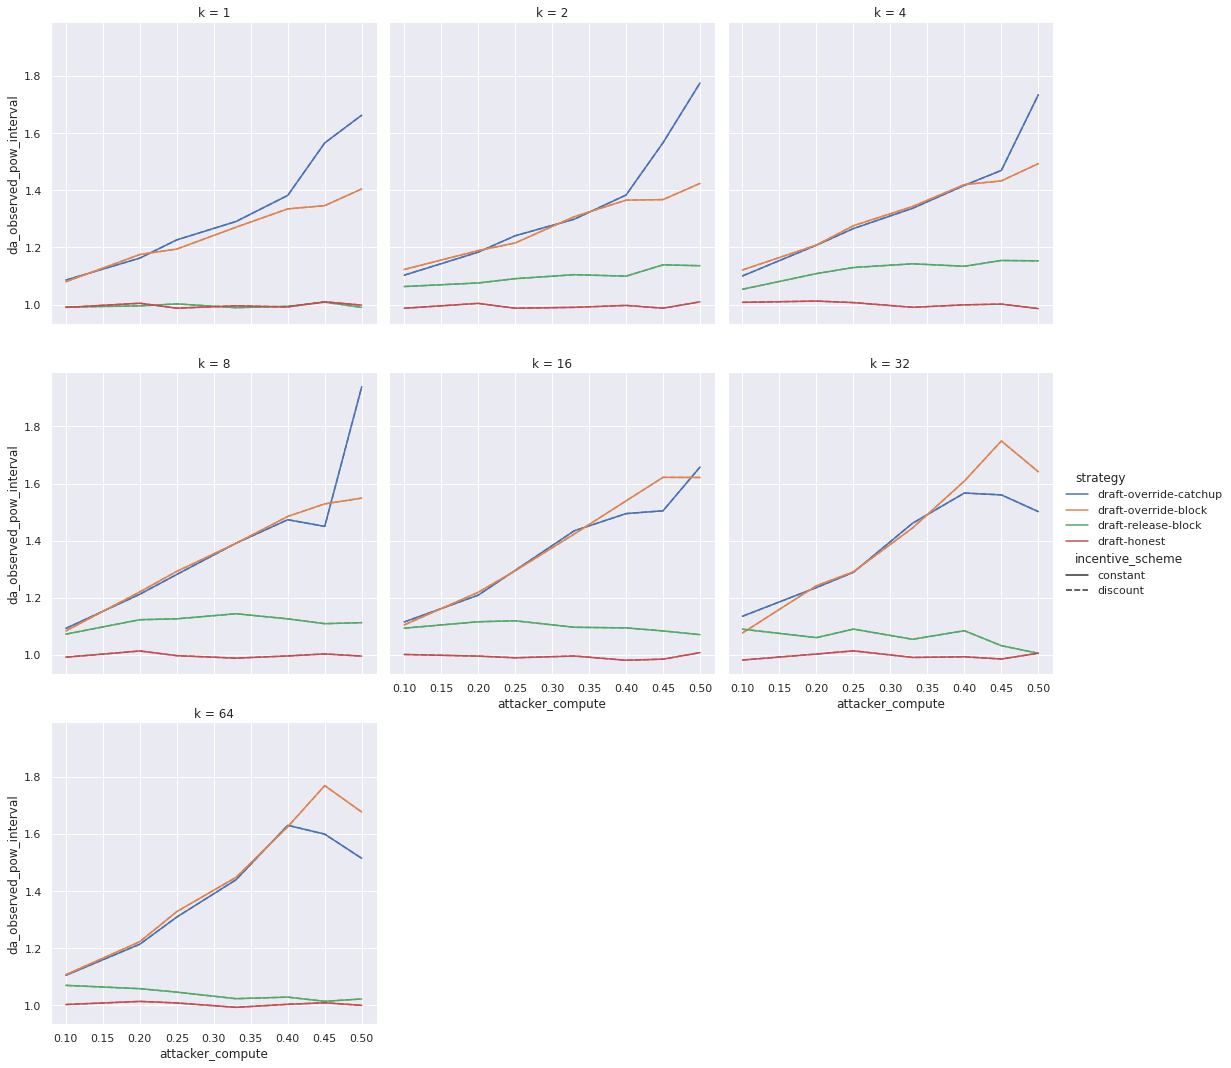

In [3]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_observed_pow_interval",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

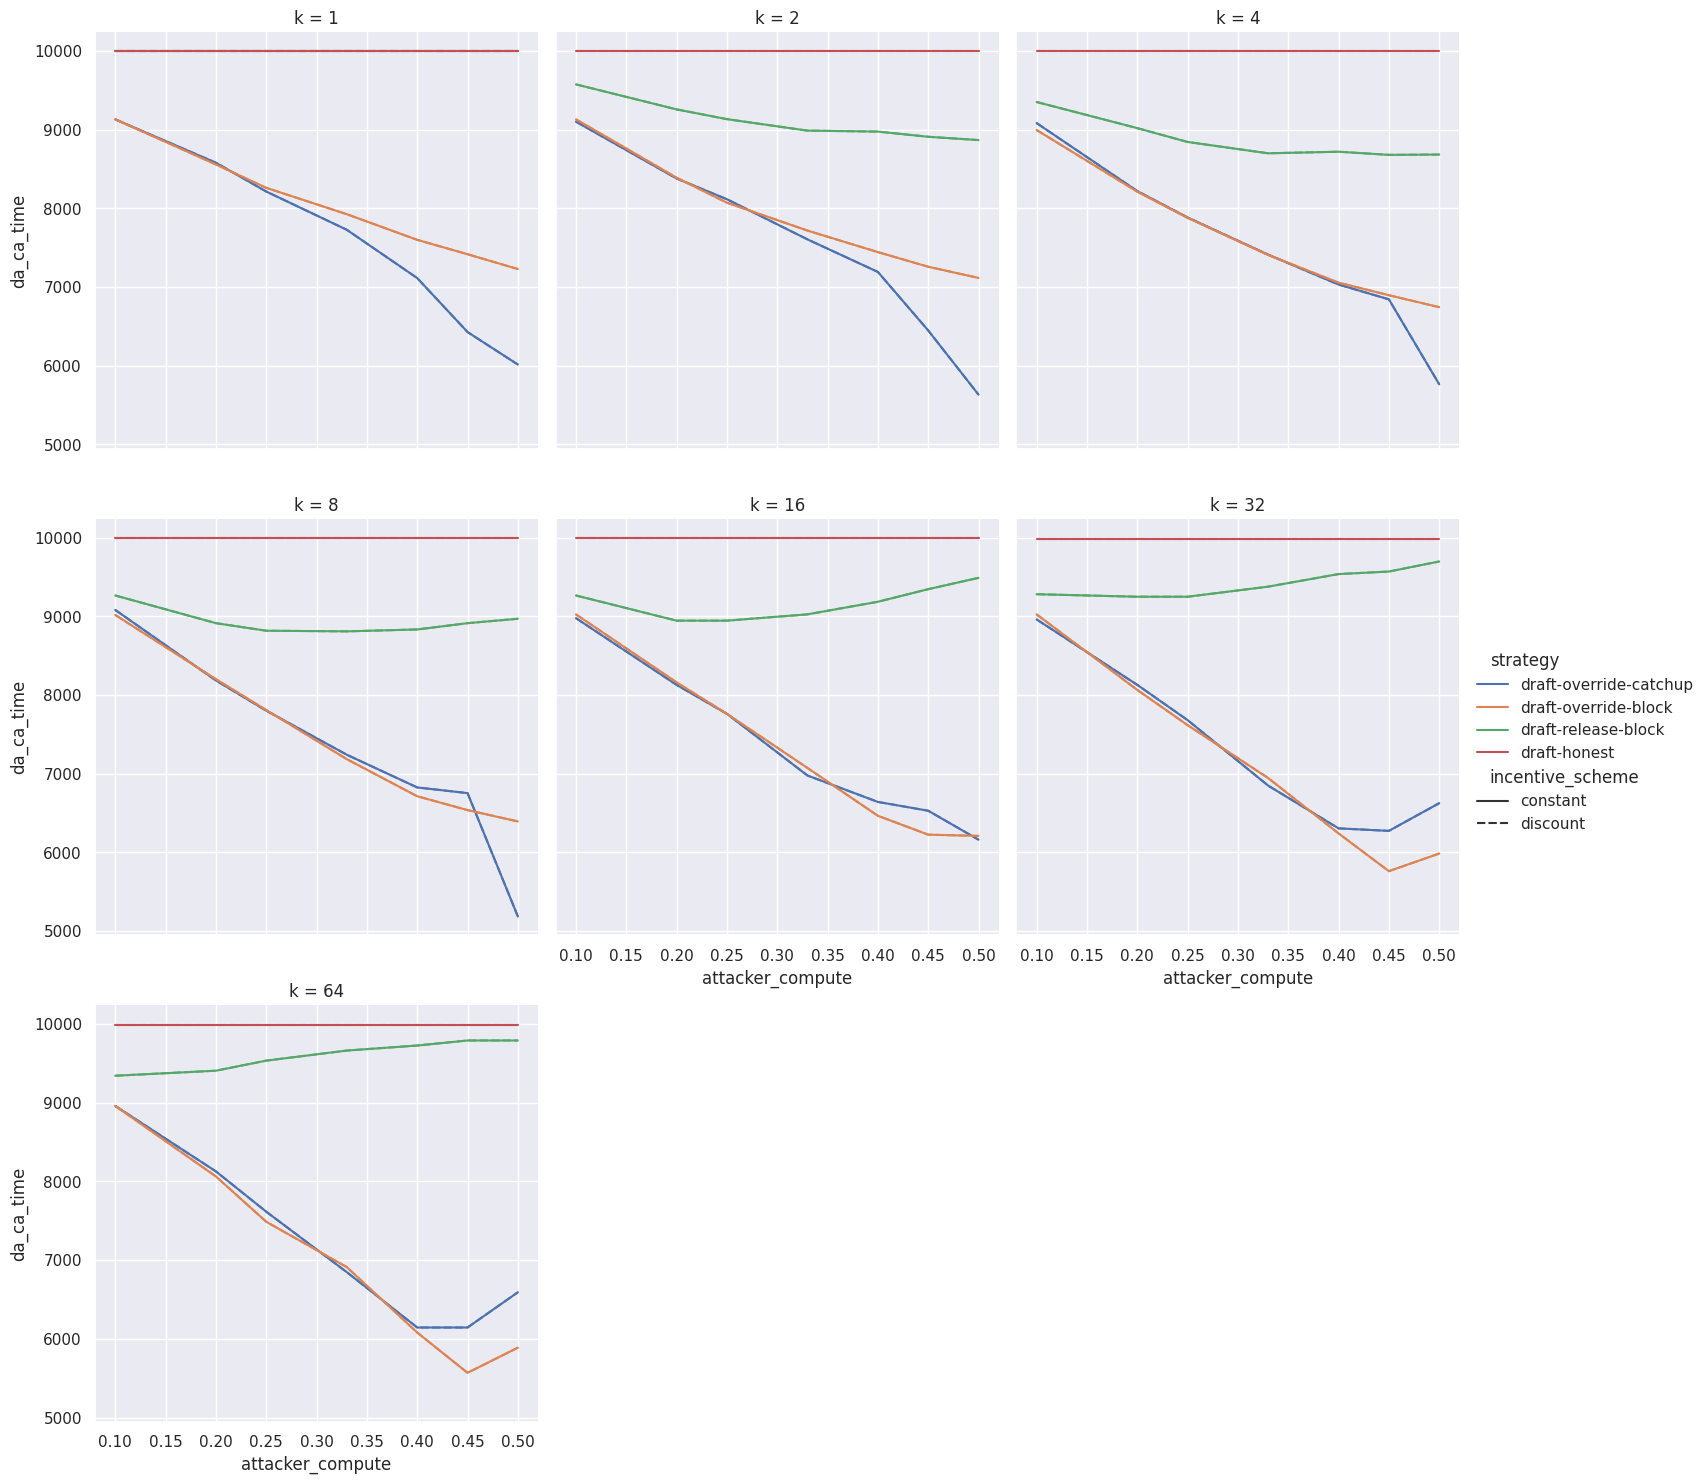

In [4]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_ca_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)

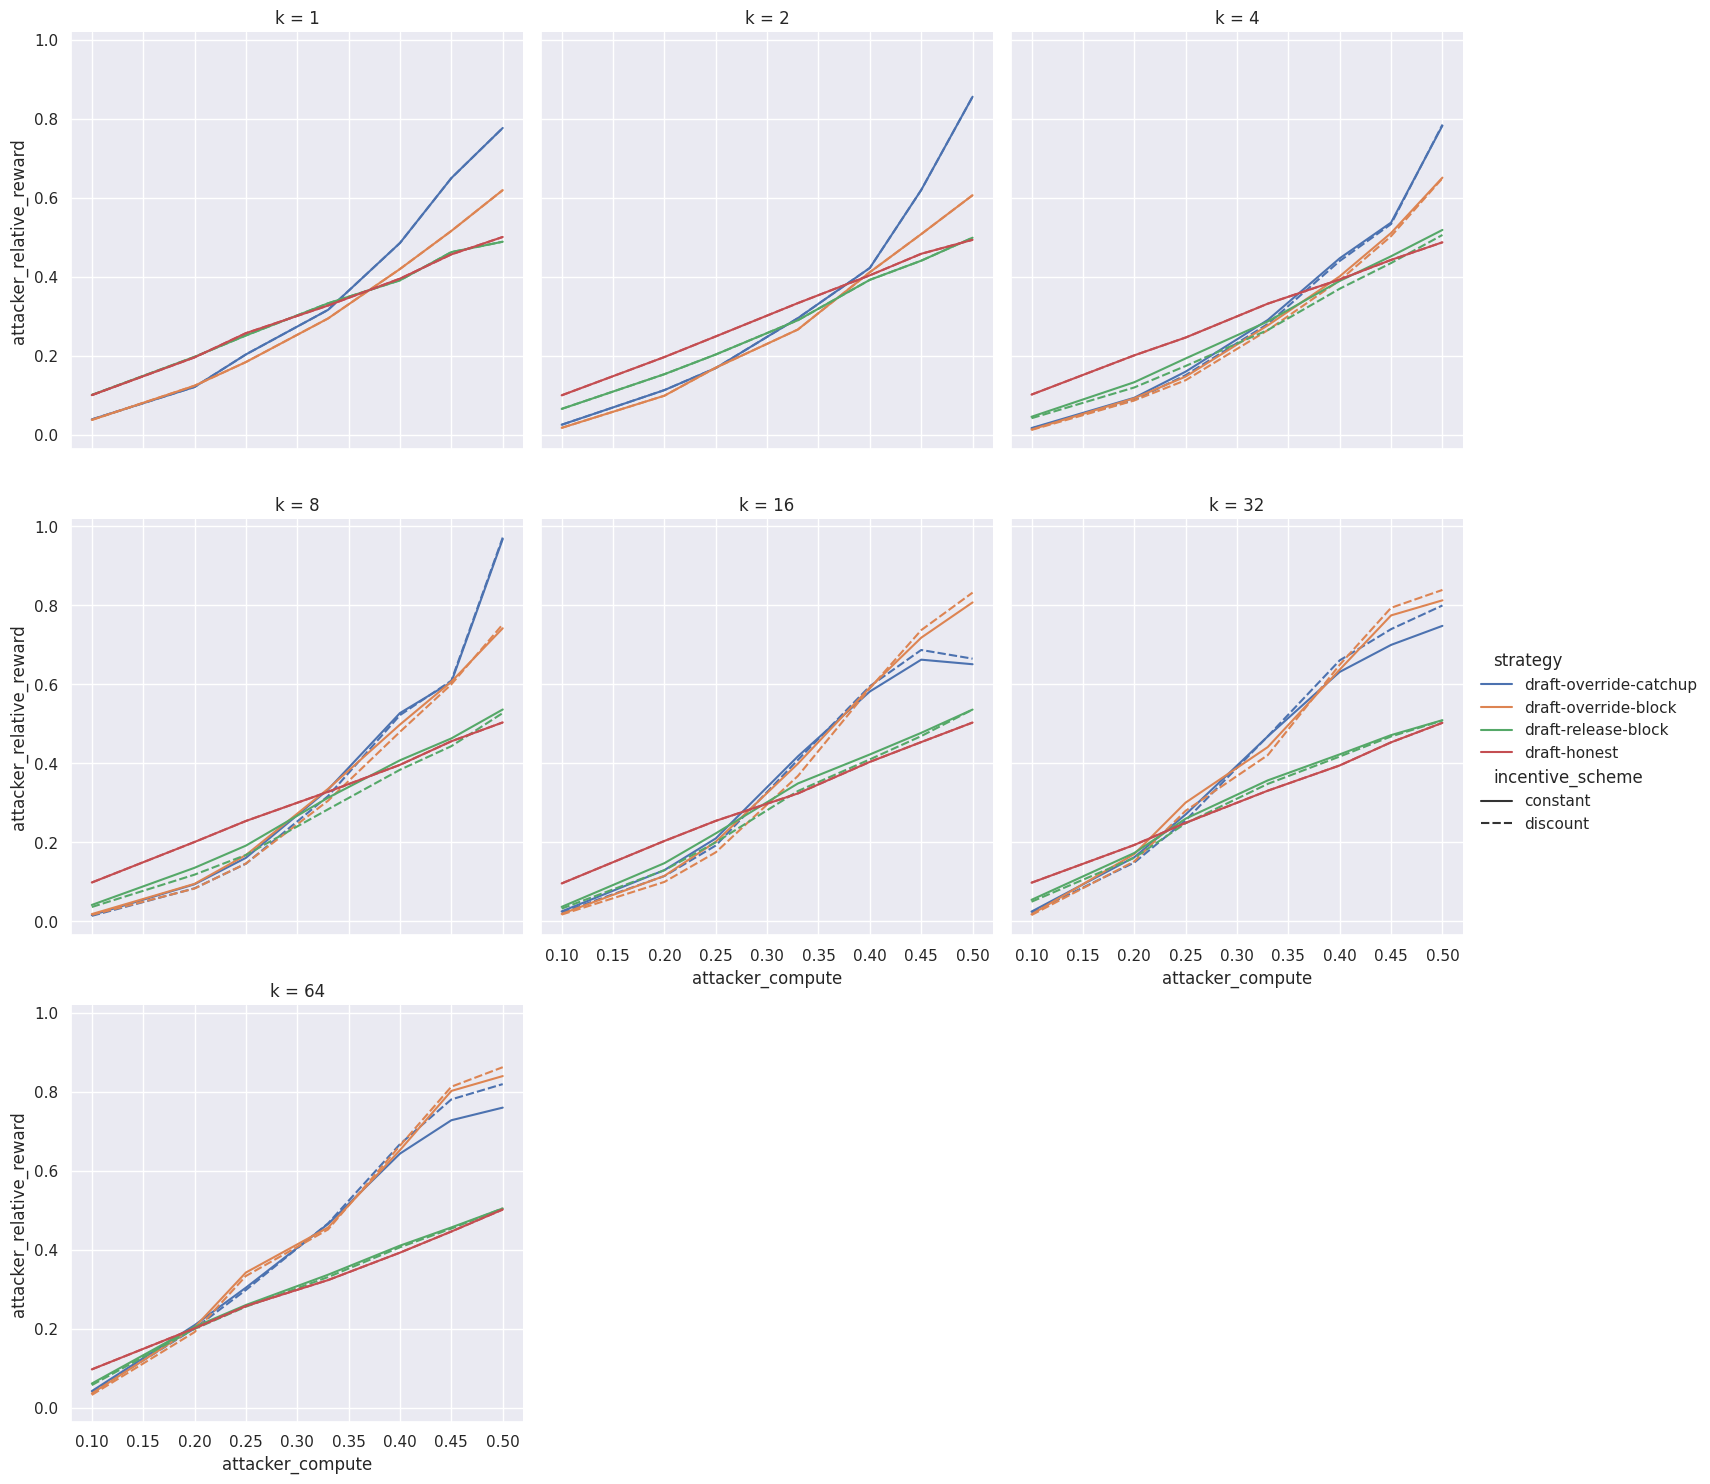

In [5]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="attacker_relative_reward",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_relative.png")

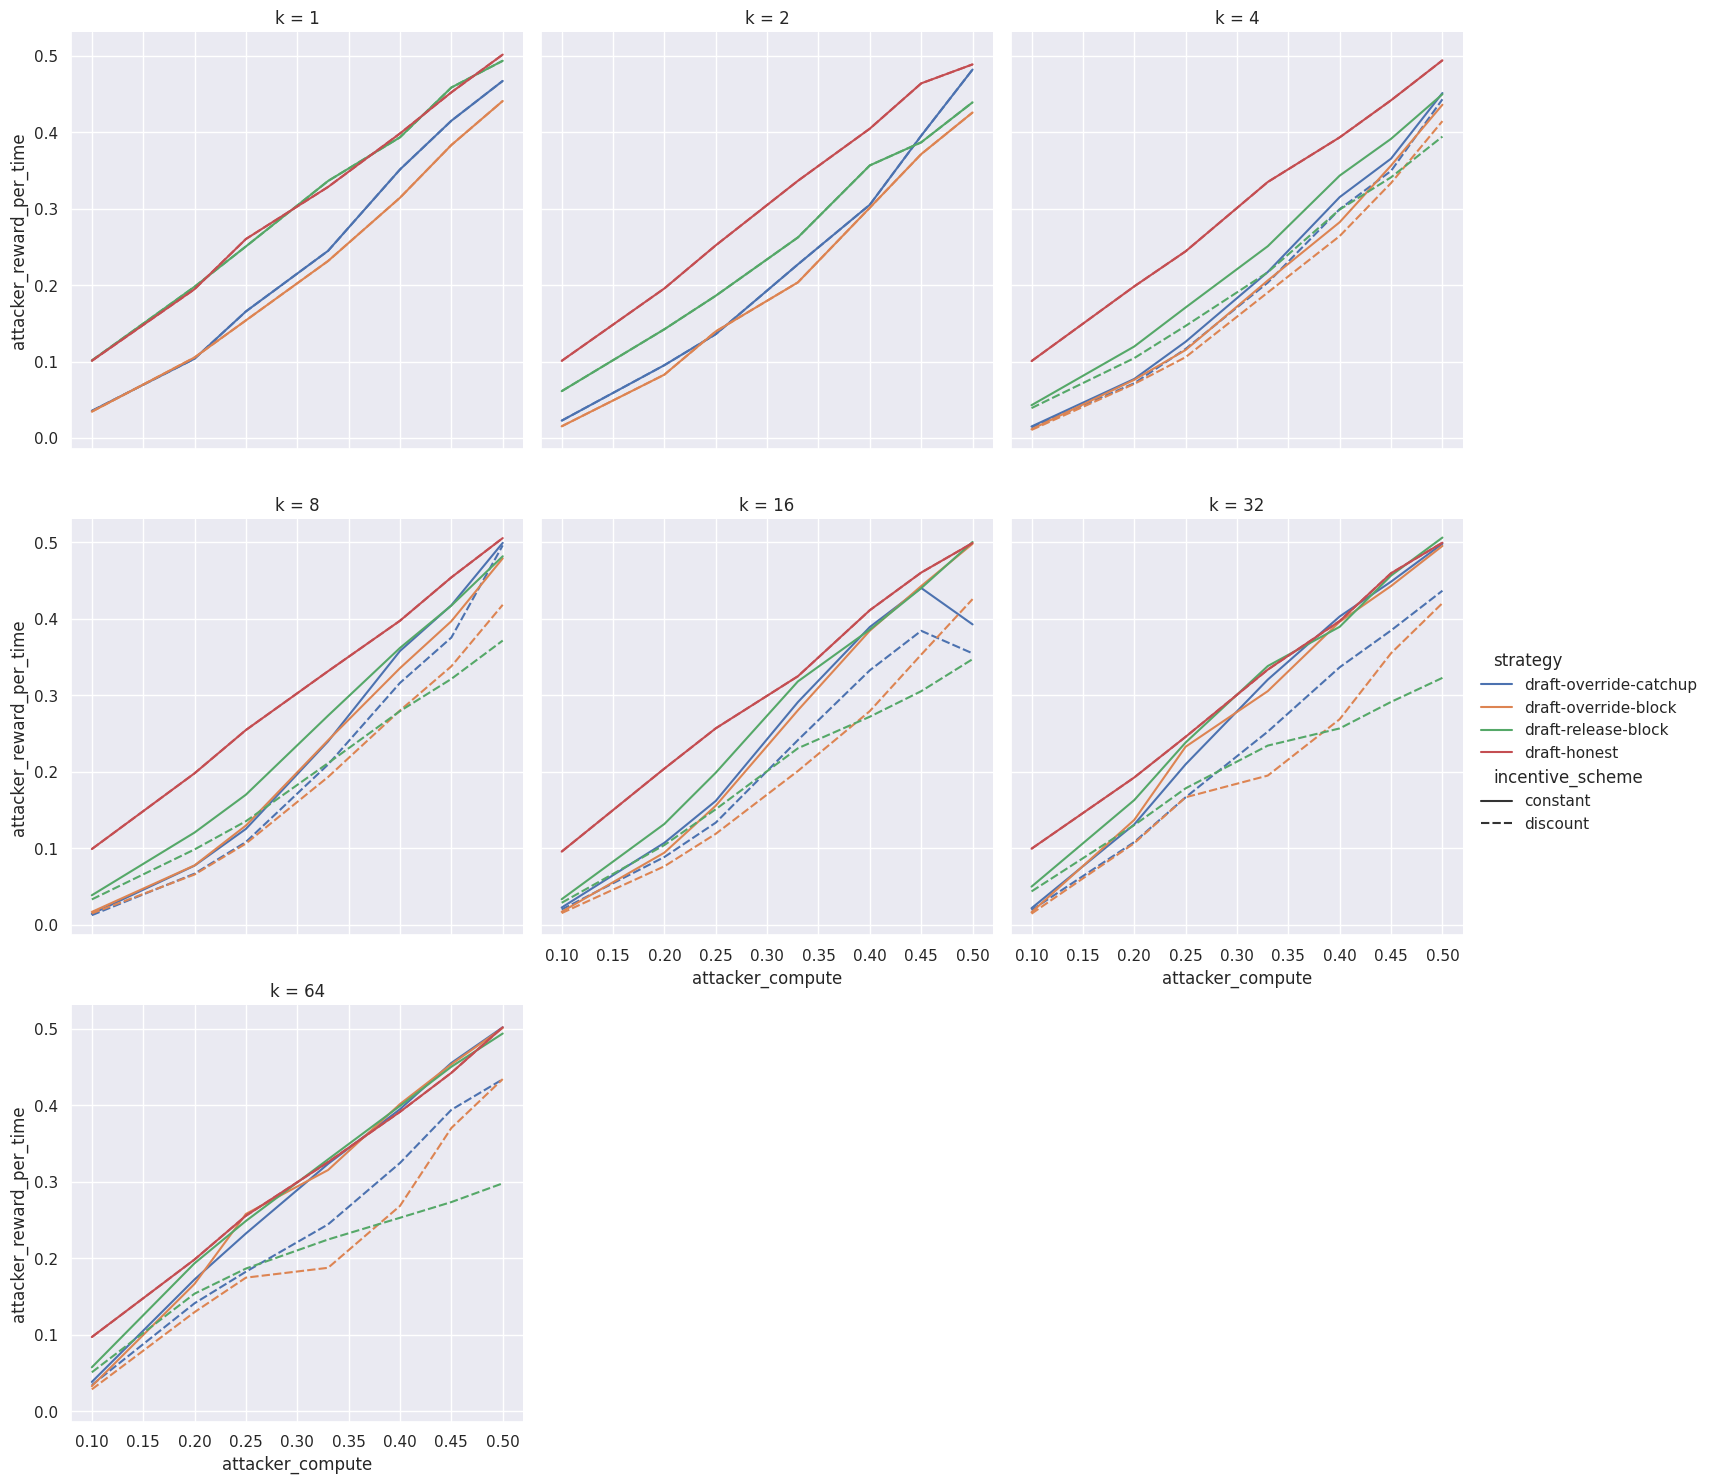

In [6]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_absolute.png")

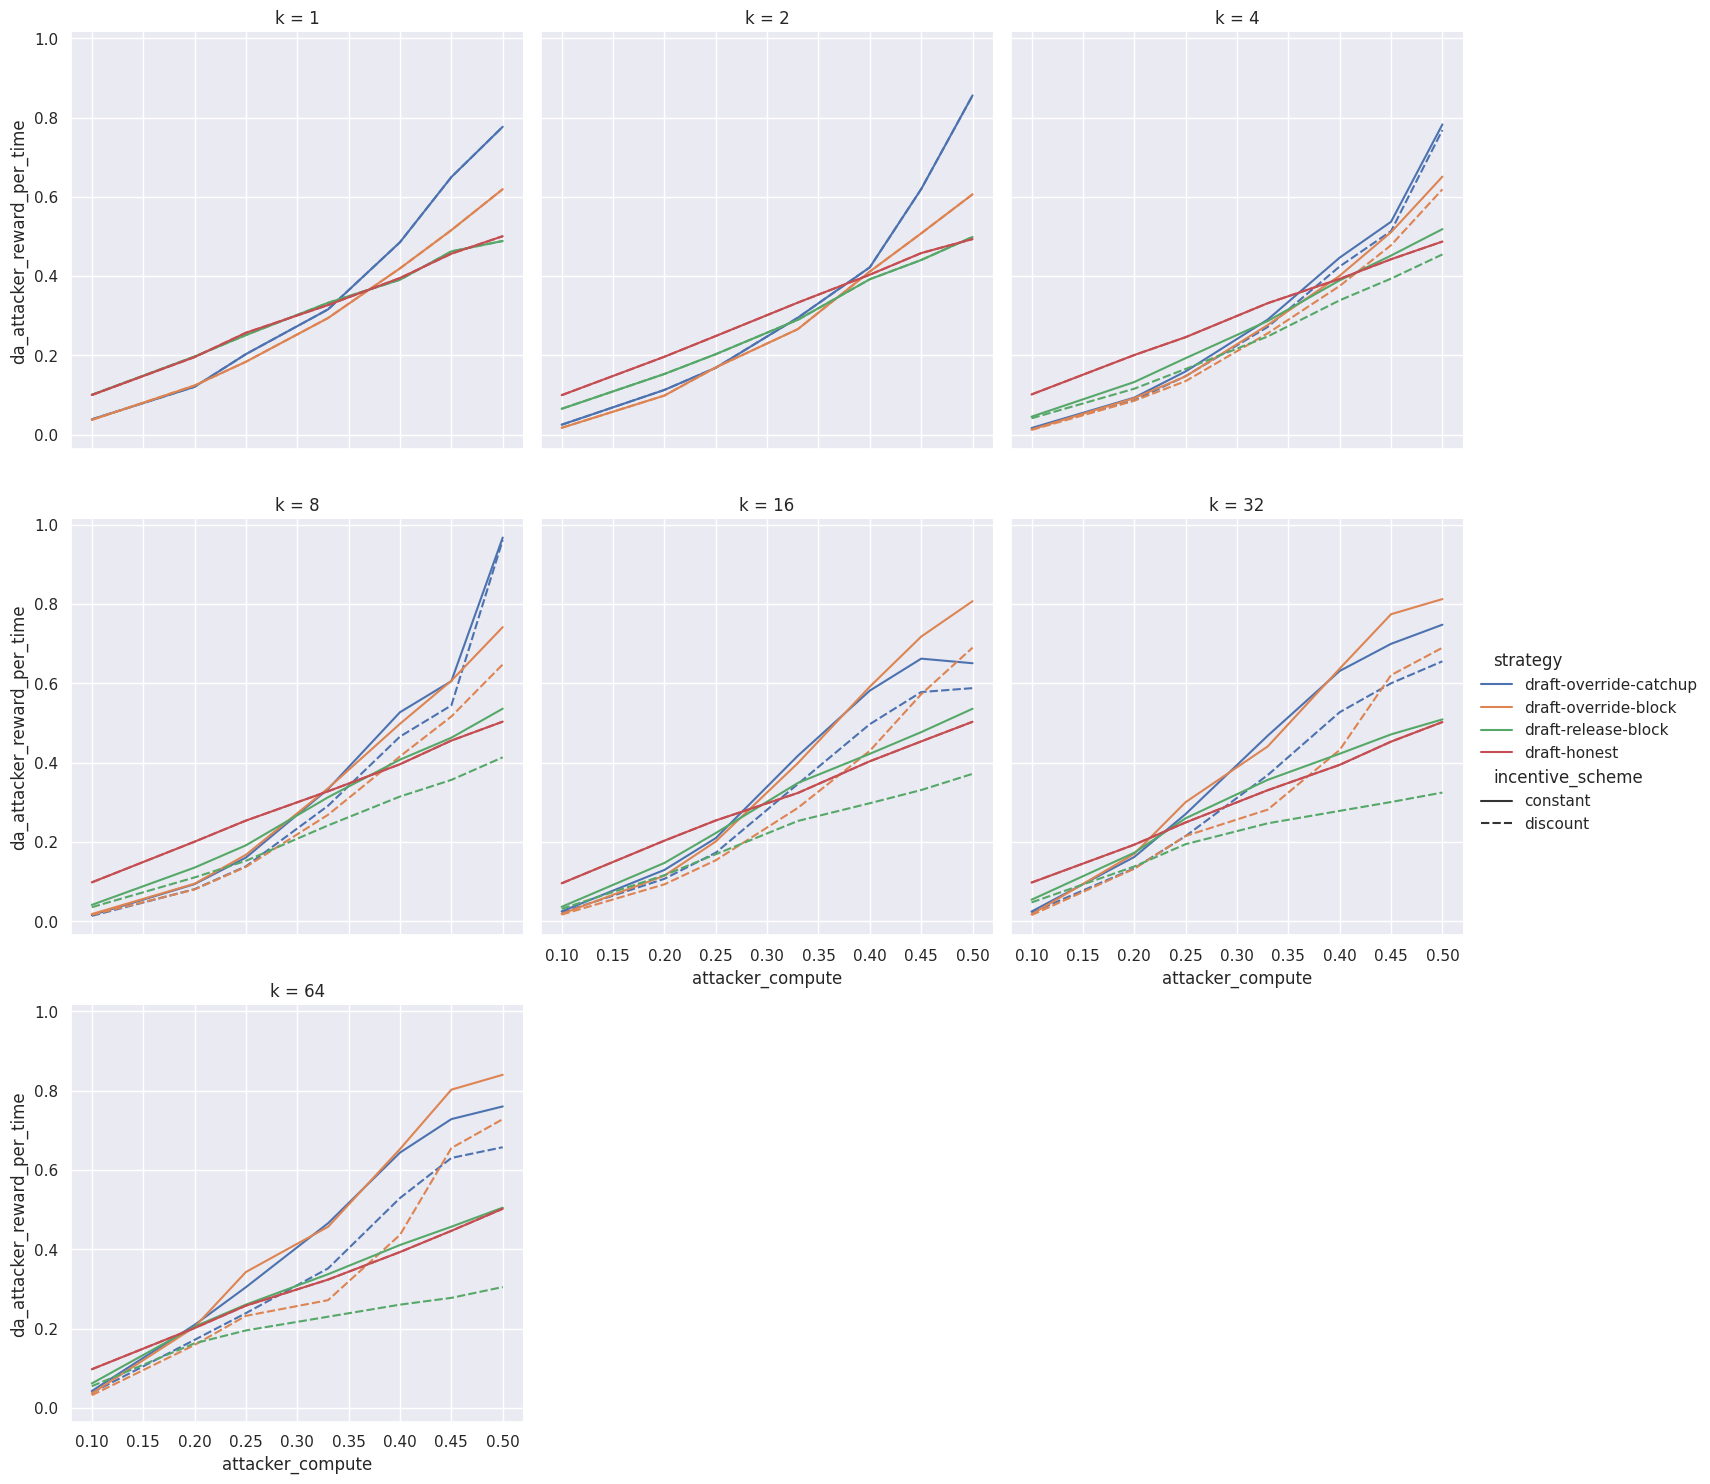

In [7]:
ax = sns.relplot(
    data=d[d.attack_space == "draft"],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="k",
    col_wrap=3,
    hue="strategy",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")

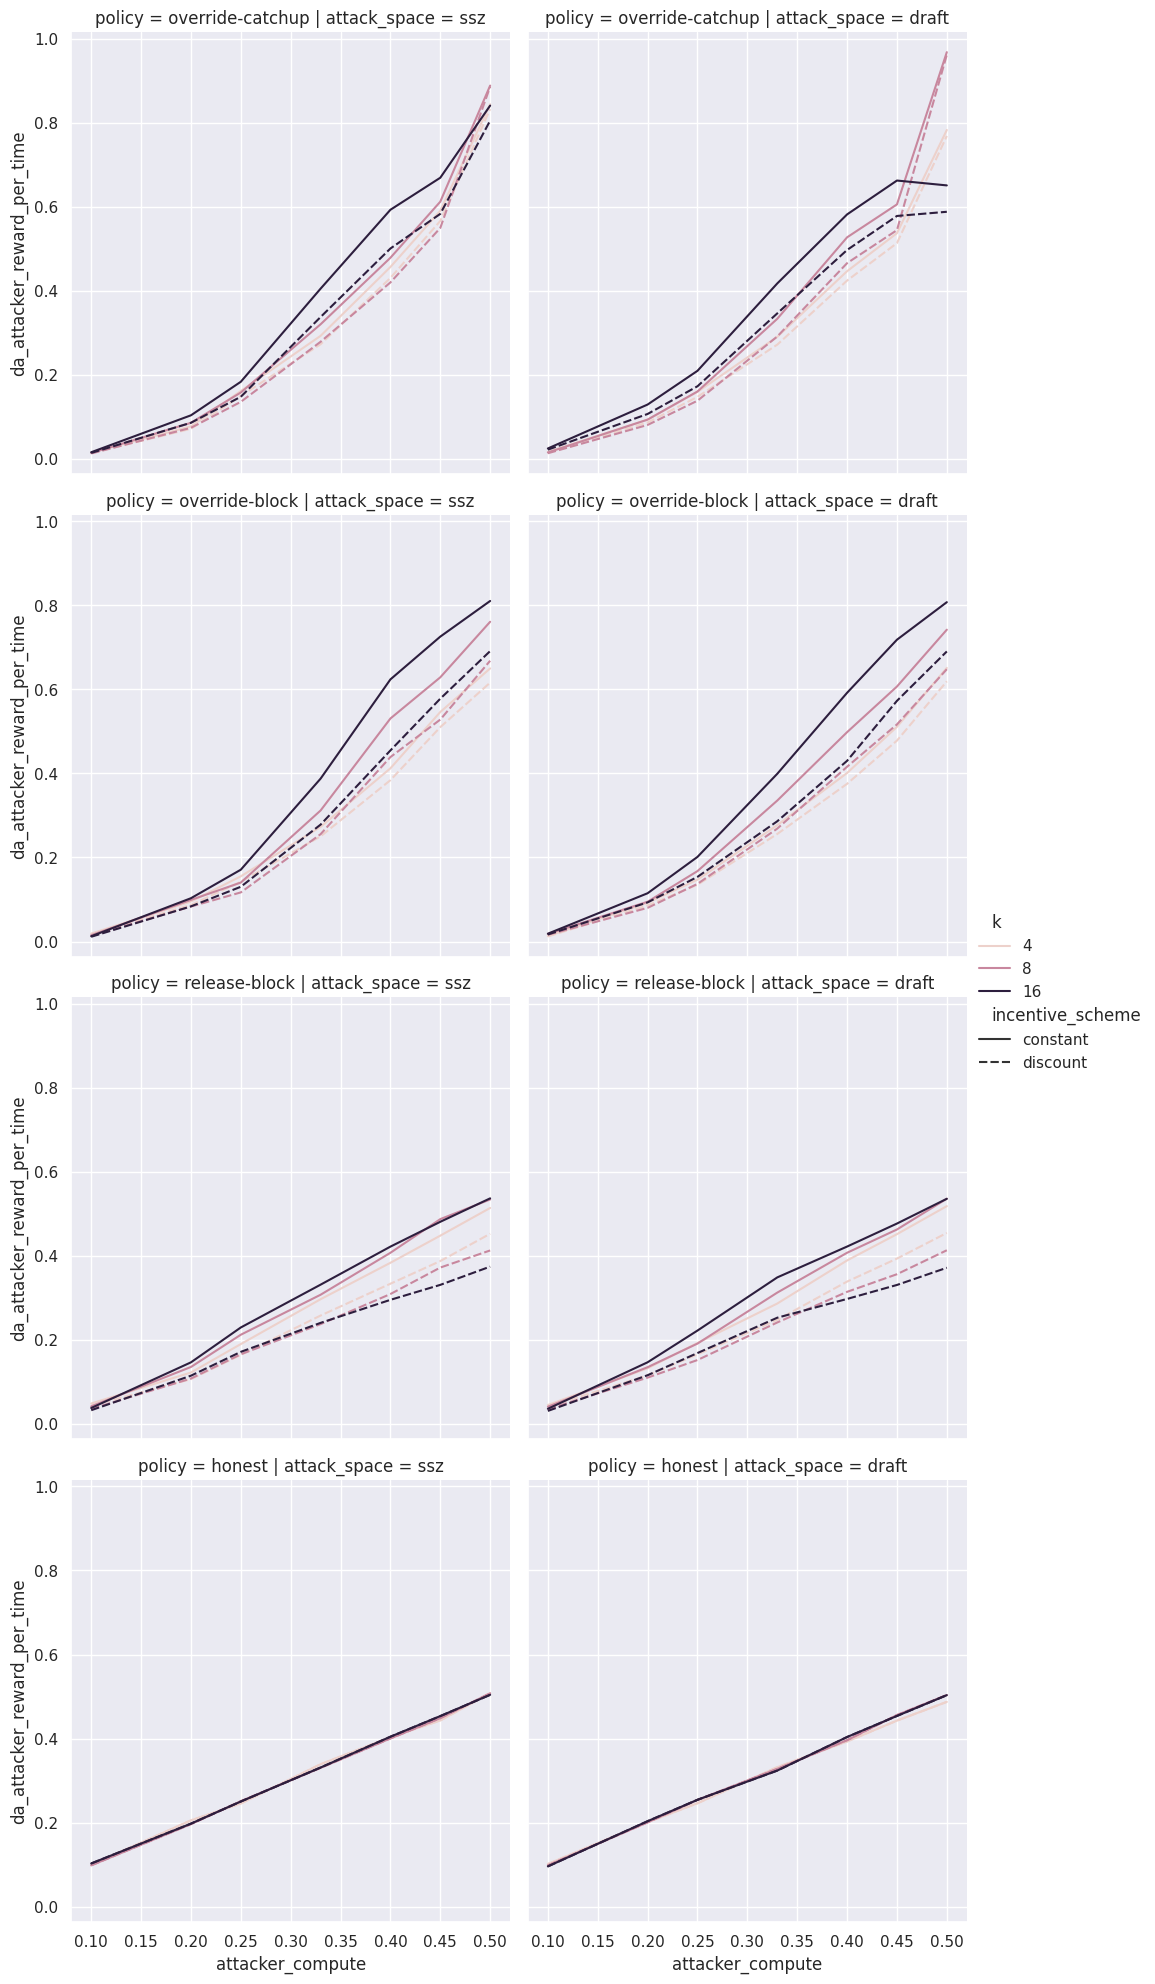

In [8]:
ax = sns.relplot(
    data=d[[k in [4, 8, 16] for k, policy in zip(d.k, d.policy)]],
    x="attacker_compute",
    y="da_attacker_reward_per_time",
    col="attack_space",
    row="policy",
    hue="k",
    style="incentive_scheme",
    kind="line",
)
ax.savefig("../../tex/george-reward-inequality/fig/withholding_daa.png")